In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict,cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from scipy.stats import boxcox
import statsmodels.api as sm

In [2]:
import numpy as np 
import pylab 
import scipy.stats as stats

In [3]:
path = os.getcwd()
path = path + '\\' + 'bodyfat.csv'
data = pd.read_csv(path)
data.head()

,Density,BodyFat,BMI,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23.624460,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,23.332048,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,24.666315,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,24.880784,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,25.514854,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [4]:
#BodyFat is the target. 

#The goal of the model is to predict BodyFat without Density. Density is removed from the data prior to training.
X_data = data.drop(['BodyFat', 'Density'],axis=1) 

#removing columns.  Relying on BMI for their information
#models were tested including these features. Performance was comparible in either case.
X_data = X_data.drop(['Height','Weight'], axis = 1)

Y_data = data['BodyFat']

X_data.head()

,BMI,Age,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,23.624460,23,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,23.332048,22,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,24.666315,22,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,24.880784,26,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,25.514854,24,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [5]:
#This cell determines if our X data is Normal

X_cols = X_data.columns.to_list()

skewlist = []
for col in X_cols:
    ob = normaltest(X_data[col])
    if ob.pvalue < 0.05:
        skewlist.append(col)


print('Skewed variables include:')        
print(skewlist)

print('\nSince obesity is an extreme condition, lets exclude it from the model')

Skewed variables include:
['BMI', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm']

Since obesity is an extreme condition, lets exclude it from the model


In [6]:
#removing all obese patients from dataset
Y_data = Y_data[X_data['BMI']<30.0]
X_data = X_data[X_data['BMI']<30.0]



In [7]:
X_data.sort_values(by="BMI",ascending=False)

,BMI,Age,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
238,29.889392,67,40.7,118.3,106.1,101.6,58.2,38.8,24.1,32.1,29.3,18.5
143,29.839185,25,40.9,110.9,100.5,106.2,68.4,40.8,24.6,33.3,29.7,18.4
245,29.769898,74,40.8,112.4,108.5,107.1,59.3,42.2,24.6,33.7,30.0,20.9
174,29.733661,39,42.8,109.5,104.5,109.9,69.5,43.1,25.8,39.1,32.5,19.9
185,29.727796,42,41.8,115.2,113.7,112.4,68.5,45.0,25.5,37.1,31.2,19.9
...,...,...,...,...,...,...,...,...,...,...,...,...
51,19.877505,49,35.1,93.3,79.6,91.6,52.6,37.6,22.6,38.5,27.4,18.5
159,19.801821,34,36.0,89.2,83.4,89.6,52.4,35.6,20.4,28.3,26.2,16.5
148,19.662217,27,34.1,88.5,72.8,91.1,53.6,36.8,23.8,27.8,26.3,17.4
144,19.225922,25,35.2,92.3,76.5,92.1,51.9,35.7,22.0,25.8,25.2,16.9


In [8]:
#another way to check for normality of the columns
print('Data with Obese people Included')
print(data.skew().sort_values(ascending=False).to_frame().rename(columns={0:'Skew'}))
print('\n\n')
print('Data with Obese people removed')
print(X_data.skew().sort_values(ascending=False).to_frame().rename(columns={0:'Skew'}))

Data with Obese people Included
             Skew
Ankle    2.289860
BMI      1.639816
Hip      1.606410
Weight   1.292419
Abdomen  0.897383
Thigh    0.855690
Chest    0.775233
Neck     0.570604
Knee     0.560494
Biceps   0.287758
Age      0.281010
Wrist    0.270985
BodyFat  0.173623
Height   0.026071
Density -0.090215
Forearm -0.223953



Data with Obese people removed
             Skew
Ankle    2.704831
Age      0.292234
Chest    0.223028
Thigh    0.187763
Knee     0.123080
Biceps   0.092918
BMI      0.075642
Abdomen  0.073981
Wrist    0.057410
Hip      0.035170
Forearm -0.060829
Neck    -0.098120


check for normality of remaining skewed columns


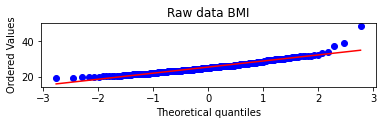

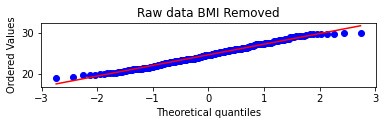

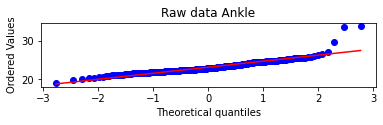

In [9]:
print('check for normality of remaining skewed columns')

plt.subplot(3,1,1)
stats.probplot(data['BMI'], dist="norm", plot=pylab)
pylab.title('Raw data BMI')
pylab.show()

plt.subplot(3,1,2)
stats.probplot(X_data['BMI'], dist="norm", plot=pylab)
pylab.title('Raw data BMI Removed')
pylab.show()

plt.subplot(3,1,3)
stats.probplot(data['Ankle'], dist="norm", plot=pylab)
pylab.title('Raw data Ankle')
pylab.show()

Looks like Ankle Might have an outlier(s)

In [10]:
#This cell determines if our X data is Normal now that we have removed obese paitents

X_cols = X_data.columns.to_list()

skewlist = []
for col in X_cols:
    ob = normaltest(X_data[col])
    if ob.pvalue < 0.05:
        skewlist.append(col)
        print('skewed column: ', col)
        
print('Nonnormal variables include:')        
print(skewlist)


skewed column:  BMI
skewed column:  Ankle
Nonnormal variables include:
['BMI', 'Ankle']


Taking a look at the remaining Skewed columns


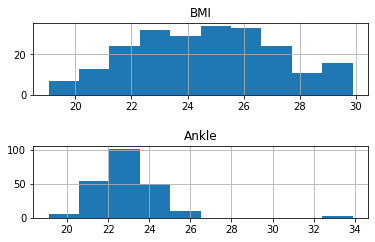

In [11]:
print('Taking a look at the remaining Skewed columns')
figure, axes = plt.subplots(nrows=2, ncols=1)
plt.subplot(2,1,1)
X_data.BMI.hist()
plt.title('BMI')
figure.tight_layout(pad=3.0)
plt.subplot(2,1,2)
plt.title('Ankle')
X_data.Ankle.hist()
plt.show()

It looks like there are remaining outliers in the ankle column.  Lets Explore

In [12]:
#grab the outlying ankle points
Cankles = X_data[X_data['Ankle']>28]
Cankles.head()

,BMI,Age,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
30,23.523539,32,38.7,100.5,88.7,99.8,57.5,38.7,33.9,32.5,27.7,18.4
82,25.767023,67,36.5,98.9,89.7,96.2,54.7,37.8,33.7,32.4,27.7,18.2


In [13]:
#deeper dive into the two 'Ankle' outliers

X_cols = X_data.columns.to_list()

#grab the mean and stdev of each column in the dataset
a = X_data.mean()
b = X_data.std()

df_meta = pd.concat([a,b],axis=1,keys=['mean','stdev'])

#construct a matrix to calculate the Z-scores for all features describing the observations with large ankle measurements.
workingdata = Cankles.transpose()
thirty = workingdata.loc[:,30]
ei2 = workingdata.loc[:,82]

#calculate Z scores for the outlying data points
df_meta['Z_30'] = (thirty - df_meta['mean'])/df_meta['stdev']
df_meta['Z_82'] = (ei2 - df_meta['mean'])/df_meta['stdev']

print('mean is of the whole column from the dataset')
print('stdev is of the whole column from the dataset')
print('Z scores for the rows with the outlying Ankle points')

#we really don't care about the age of the patient for this analysis
df_meta = df_meta.drop(['Age'],axis=0)
df_meta


mean is of the whole column from the dataset
stdev is of the whole column from the dataset
Z scores for the rows with the outlying Ankle points


,mean,stdev,Z_30,Z_82
BMI,24.653439,2.561873,-0.441044,0.434676
Neck,37.686547,2.138619,0.473882,-0.554819
Chest,99.269955,6.601170,0.186337,-0.056044
Abdomen,90.568610,8.417234,-0.221998,-0.103194
Hip,98.601345,5.323774,0.225151,-0.451061
Thigh,58.662780,4.401321,-0.264189,-0.900362
Knee,38.256054,2.090766,0.212337,-0.218128
Ankle,22.975336,1.617659,6.753378,6.629742
Biceps,31.907175,2.785021,0.212862,0.176956
Forearm,28.508072,1.878165,-0.430245,-0.430245


We see that these two observations have measurements within 1 standard deviation of the mean for each feature except for Ankle.

This leads me to believe that these data points are true outliers, possibly explained by measurement errors. 

These observations are removed from the analysis



In [14]:
#remove rows containing the outlying Ankle measurements
Y_data=Y_data[X_data['Ankle']<30]
X_data=X_data[X_data['Ankle']<30]


In [15]:
print('checking the skew of the data without the ankle outliers')

X_data.skew().apply(abs).sort_values(ascending = False)

checking the skew of the data without the ankle outliers


Age        0.287797
Chest      0.223845
Ankle      0.194663
Thigh      0.175550
Knee       0.122536
Neck       0.098850
Biceps     0.097802
BMI        0.075432
Forearm    0.071734
Abdomen    0.069302
Wrist      0.061979
Hip        0.032356
dtype: float64

All columns are within acceptable skew limits.

In [16]:
#boxcox transformation to normalize BMI column
bc_result = boxcox(X_data.BMI)
boxcox_BMI = bc_result[0]
lam = bc_result[1]
pd.Series(boxcox_BMI).skew()

-0.013824911723240671

NormaltestResult(statistic=9.911185357125358, pvalue=0.007043904271179539)


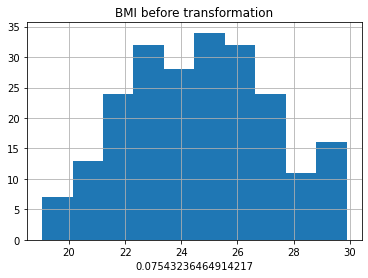

In [17]:
X_data['BMI'].hist()
print(normaltest(X_data['BMI']))
plt.title('BMI before transformation')
plt.xlabel(X_data['BMI'].skew())
plt.show()

NormaltestResult(statistic=9.592389831077183, pvalue=0.008261121585162443)
Boxcox failed to normalize


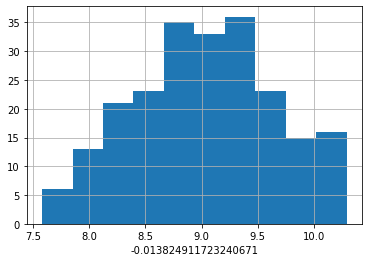

In [18]:
pd.Series(boxcox_BMI).hist()
print(normaltest(boxcox_BMI))
plt.xlabel(pd.Series(boxcox_BMI).skew())
print('Boxcox failed to normalize')



Even with the boxcox transformation we are unable to normalize BMI.  
Too many overweight people in the dataset.

However, I think removing the overweight people would limit the robustness of the model.

In [19]:
print('Do the linear regression with the BMI boxcox transformation')

#copy features and replace BMI with transformed version
print('\n')
s = StandardScaler()
df_bx = X_data.copy()
df_bx['BMI']=boxcox_BMI

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df_bx, Y_data, test_size=0.3, random_state=72018)

X_train_sb = s.fit_transform(X_train_b)
X_test_sb = s.transform(X_test_b)

print('Standardized Data')
lrbs = LinearRegression()
lrbs.fit(X_train_sb,y_train_b)
y_pred_b = lrbs.predict(X_test_sb)
rb = r2_score(y_test_b, y_pred_b)
print('r2 = ', str(rb))

print('\n')
print('Unstandardized Data')
lrb = LinearRegression()
lrb.fit(X_train_b,y_train_b)
y_pred_b = lrb.predict(X_test_b)
r = r2_score(y_test_b, y_pred_b)
print('r2 = ', r)


cross_val_score(lrb,df_bx,Y_data,cv=3)

Do the linear regression with the BMI boxcox transformation


Standardized Data
r2 =  0.6588604485397735


Unstandardized Data
r2 =  0.6588604485397732


array([0.716735  , 0.41479759, 0.60762681])

### Initializing Data for remaining analysis - keep the splits the same for each flavor of regression.

#### Model 2: Linear Regression without Polynomial Features

In [20]:
print('Use this split for other models - no pfs')

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=72018)
X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

Use this split for other models - no pfs


This cell is intended to compare a plain linear regression model using a standard BMI feature to the model above, which used the boxcox transformed BMI.


In [21]:
print('Do the linear regression without the BMI boxcox transformation')
print('\n')

print('Unstandardized Data')
print('experimentation purpose only')
lrs = LinearRegression()
lrs.fit(X_train,y_train)
y_pred = lrs.predict(X_test)
sumcoeff = abs(lrs.coef_).sum()
print('r2 = ', r)
r = r2_score(y_test,y_pred)
print('sum of |coef| = ', sumcoeff)
#cross_val_score(lrs,X_data,Y_data,cv=3)


print('\n')

print('Standardized Data')

#training the base linear regression model for comparison with regularization
lr = LinearRegression()
lr.fit(X_train_s,y_train)
y_pred = lr.predict(X_test_s)
r = r2_score(y_test,y_pred)
print('r2 = ', r)
sumcoeff = abs(lr.coef_).sum()
print('sum of |coef| = ', sumcoeff)





cross_val_score(lrs,X_data,Y_data,cv=3,scoring="r2")

Do the linear regression without the BMI boxcox transformation


Unstandardized Data
experimentation purpose only
r2 =  0.6588604485397732
sum of |coef| =  5.222499359838723


Standardized Data
r2 =  0.6595069658408614
sum of |coef| =  14.80397900365175


array([0.71656651, 0.41441078, 0.60858326])

### The boxcox transform of BMI did not have any bearing on model performance.  


In [22]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



### Model 3: Lasso Regression without Polynomial Features

In [23]:
print('using the same test/train/split as LR above')

print('Lasso Regression')

#Use the lassoCV function to come up with alpha

lassoCV = LassoCV(alphas=None,
                  max_iter=5e4,
                  cv=3).fit(X_train_s, y_train)

alpha = lassoCV.alpha_
print('alpha = ', alpha)

y_pred_lasso = lassoCV.predict(X_test_s)
print('r2 =', r2_score(y_test,y_pred_lasso))

print(abs(lassoCV.coef_).sum())



using the same test/train/split as LR above
Lasso Regression
alpha =  0.22255635039618565
r2 = 0.6610996447632823
10.090301326884902


[0.71561876 0.42651604 0.6318831 ]


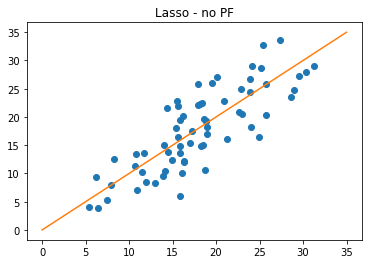

In [24]:
plt.plot(y_pred_lasso,y_test,'o',[0,35],[0,35])
plt.title('Lasso - no PF')
print(cross_val_score(lassoCV, X_data, Y_data, cv=3))

### Model 4: Ridge Regression without Polynomial Features

In [25]:
print('Ridge Regression')

alphas2 = np.linspace(0,10,300)

ridgeCV = RidgeCV(alphas=alphas2,
                  cv=3).fit(X_train_s, y_train)

alpha = ridgeCV.alpha_

print('alpha = ', alpha)

y_pred_ridge = ridgeCV.predict(X_test_s)
print('r2 =', r2_score(y_test,y_pred_ridge))
coef = abs(ridgeCV.coef_).sum()

print('sum of |coef| = ', coef)

print('Cross Val R2 = ')
print(cross_val_score(ridgeCV, s.fit_transform(X_data), Y_data, cv=3).mean())

Ridge Regression
alpha =  9.665551839464882
r2 = 0.6369213326320788
sum of |coef| =  12.4184986777955
Cross Val R2 = 
0.5790917970379036


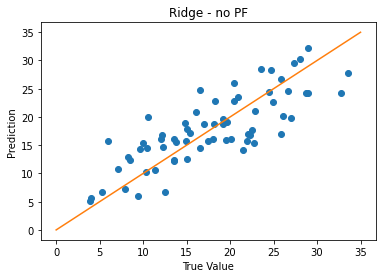

In [26]:
plt.plot(y_test,y_pred_ridge,'o',[0,35],[0,35])
plt.title('Ridge - no PF')
plt.xlabel('True Value')
plt.ylabel('Prediction')
plt.show()

### Comparing the coeficients of each feature for models 2-4

In [27]:
print('Looking at the Coefs of the models trained on standardized X_data')
print('\n with standardized data')

cols = X_data.columns.to_list()
lrc = lr.coef_
lasc = lassoCV.coef_
ridgec = ridgeCV.coef_
dict1 = {'LR':lrc,'Ridge': ridgec, 'Lasso':lasc}
noPFdf = pd.DataFrame(dict1,index=cols)

#pd.DataFrame(noPFdf.abs)

noPFdf.abs().sort_values(by='Lasso',ascending=False)

Looking at the Coefs of the models trained on standardized X_data

 with standardized data


,LR,Ridge,Lasso
Abdomen,6.615432,4.780401,5.901866
Wrist,2.005245,1.723832,1.683965
BMI,2.105915,1.979395,1.183187
Age,0.930067,1.172316,0.754612
Neck,1.292544,0.939983,0.400140
Ankle,0.217619,0.414232,0.166531
Chest,0.259646,0.603475,0.000000
Hip,0.763956,0.147820,0.000000
Thigh,0.141944,0.325256,0.000000
Knee,0.008196,0.086471,0.000000


### Degree 2 PFs

In [28]:
#2nd degree polynomial features

pf = PolynomialFeatures(degree=2, include_bias=False)
X_poly2 = pf.fit_transform(X_data)

X_train, X_test, y_train, y_test = train_test_split(X_poly2, Y_data, test_size=0.3, 
                                                    random_state=72018)
X_train_s2 = s.fit_transform(X_train)
X_test_s2 = s.transform(X_test)

#### Model 5 - Linear regression - Degree 2 PFs

Linear Regression - 2nd degree
r2 = 0.42004598800480486


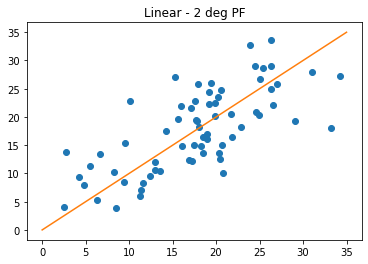

In [29]:
print('Linear Regression - 2nd degree')

lr2 = LinearRegression()
lr2.fit(X_train_s2,y_train)
y_pred = lr2.predict(X_test_s2)

r = r2_score(y_test,y_pred)

print('r2 =', r)

plt.plot(y_pred,y_test,'o',[0,35],[0,35])
plt.title('Linear - 2 deg PF')
plt.show()

### Model 6 - Ridge Regression - degree 2 PFs

Ridge Regression - 2nd degree
alpha =  56.785714285714285
r2 = 0.6333990612032756
15.798597744936808


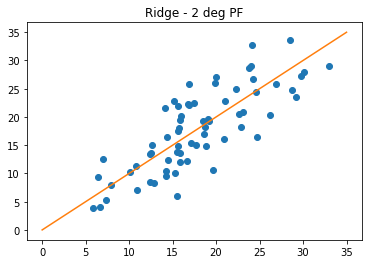

In [30]:
print('Ridge Regression - 2nd degree')

alphas2 = np.linspace(55,60, 15)

ridgeCV2 = RidgeCV(alphas=alphas2,
                  cv=3).fit(X_train_s2, y_train)

#lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))
alpha = ridgeCV2.alpha_

print('alpha = ', alpha)

y_pred_ridge = ridgeCV2.predict(X_test_s2)
print('r2 =', r2_score(y_test,y_pred_ridge))

plt.plot(y_pred_ridge,y_test,'o',[0,35],[0,35])
plt.title('Ridge - 2 deg PF')
#print('Cross Val R2 = ')
#print(cross_val_score(ridgeCV, X_data, Y_data, cv=3))

print(abs(ridgeCV2.coef_).sum())


### Model 7 - Lasso Regression - degree 2 PFs

In [31]:
print('using the same 2nd order pf and test/train/split as Ridge above')


print('Lasso Regression - 2nd degree')

#Use the lassoCV function to come up with alpha

lassoCV2 = LassoCV(alphas=np.linspace(.20,.3,8),
                  max_iter=5e4,
                  cv=3).fit(X_train_s2, y_train)

alpha = lassoCV2.alpha_
print('alpha = ', alpha)

y_pred_lasso = lassoCV2.predict(X_test_s2)
print('r2 =', r2_score(y_test,y_pred_lasso))

print(abs(lassoCV2.coef_).sum())



using the same 2nd order pf and test/train/split as Ridge above
Lasso Regression - 2nd degree
alpha =  0.2571428571428571
r2 = 0.6603979823818057
9.677783160933009


### Degree 4 PFs

In [32]:
pf4 = PolynomialFeatures(degree=4, include_bias=False)
X_polyg = pf4.fit_transform(X_data)

X_train, X_test, y_train, y_test = train_test_split(X_polyg, Y_data, test_size=0.3, 
                                                    random_state=72018)

X_train_sg = s.fit_transform(X_train)
X_test_sg = s.transform(X_test)

### Model 8 - Ridge Regression - degree 4 PFs

Ridge Regression
alpha =  741.4141414141415
r2 = 0.6119352857589342
20.9038591948963


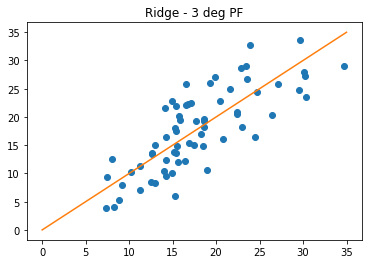

In [33]:
print('Ridge Regression')
a = 700
b = 800
alphas2 = np.linspace(a,b, 100)

ridgeCV = RidgeCV(alphas=alphas2,
                  cv=3).fit(X_train_sg, y_train)

#lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))
alpha = ridgeCV.alpha_

print('alpha = ', alpha)

y_pred_ridge = ridgeCV.predict(X_test_sg)
print('r2 =', r2_score(y_test,y_pred_ridge))

plt.plot(y_pred_ridge,y_test,'o',[0,35],[0,35])
plt.title('Ridge - 3 deg PF')
#print('Cross Val R2 = ')
#print(cross_val_score(ridgeCV, X_data, Y_data, cv=3))7


print(abs(ridgeCV.coef_).sum())


### Model 9 - Lasso Regression - degree 4 PFs

In [34]:
print('using the same 4th order pf and test/train/split as Ridge above')

print('Lasso Regression')

#Use the lassoCV function to come up with alpha


lassoCV = LassoCV(alphas=np.linspace(.2,.3,8),
                  max_iter=5e4,
                  cv=3).fit(X_train_sg, y_train)

#lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))
alpha = lassoCV.alpha_
print('alpha = ', alpha)

y_pred_lasso = lassoCV.predict(X_test_sg)
print('r2 =', r2_score(y_test,y_pred_lasso))

print(abs(lassoCV.coef_).sum())



using the same 4th order pf and test/train/split as Ridge above
Lasso Regression
alpha =  0.2857142857142857
r2 = 0.6604355510569477
9.336873110015224


## GridSearch 

### Ridge

In [35]:
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1,2,3],
    'ridge_regression__alpha': np.geomspace(2.5, 15, 30)
}

r_grid = GridSearchCV(estimator, params, cv=3)

In [36]:
r_grid.fit(X_data, Y_data)
print(r_grid.best_score_, r_grid.best_params_)
gp = r_grid.predict(X_data)
r2_score(Y_data,gp)

0.5832883097851893 {'polynomial_features__degree': 1, 'ridge_regression__alpha': 3.0091124245911667}


0.6880295802967116

### Lasso

In [37]:
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("Lasso_regression", Lasso(max_iter=5e5))])

params = {
    'polynomial_features__degree': [1,2,3],
    'Lasso_regression__alpha': np.geomspace(.001, 1, 10)
}

a_grid = GridSearchCV(estimator, params, cv=3)


In [38]:
a_grid.fit(X_data, Y_data)
print(a_grid.best_score_, a_grid.best_params_)
gp = a_grid.predict(X_data)
r2_score(Y_data,gp)

0.6199245257636469 {'Lasso_regression__alpha': 0.21544346900318823, 'polynomial_features__degree': 2}


0.6992715996993318

# General Note

In [39]:
#the IBM course had the order of r2_scores arguements messed up in some locations
#the code below was for my own sanity!!!

r = r2_score(y_test,y_pred)
print('correct:')
print('test/pred = ', r )
r = r2_score(y_pred,y_test)
print('incorrect:')
print('pred/test = ', r )


correct:
test/pred =  0.42004598800480486
incorrect:
pred/test =  0.41570028679386384
